In [1]:
from UNETPyTorch.UnetModel import DiffusionUNETModel

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Create function to load dataset
def load_transformed_dataset(img_size):
    data_transforms = [
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transform)
    test = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transform)

    return torch.utils.data.ConcatDataset([train, test])

In [3]:
# Get data into dataloader
IMG_SIZE = 64
BATCH_SIZE = 100
data = load_transformed_dataset(IMG_SIZE)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dataloader

In [5]:
# Create model
dimensions = 2
channels = 3
conv_filters = [64, 128, 256, 512]
mnist_classes = 10
my_out_layer = nn.Conv2d(conv_filters[0], channels, 1)
optim_loss_rate = 0.002
time_steps = 300

model = DiffusionUNETModel(
    name='unet_diffusion_cifar10_model', in_dimensions=dimensions, in_channels=channels, conv_channels=conv_filters,
    out_layer=my_out_layer, use_up_atten=True, use_dconv_bn=True, use_dconv_relu=True, loss_rate=optim_loss_rate,
    time_steps=time_steps, time_embed_count=32
)
model.model

UNETTwo(
  (time_embeds): Sequential(
    (0): DiffusionSinPosEmbeds()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (down_samplers): ModuleList(
    (0): DownSampleTwo(
      (conv): DoubleConvTwo(
        (first_conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (embed_adjuster): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
          (1): ReLU()
        )
        (sec_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownSampleTw

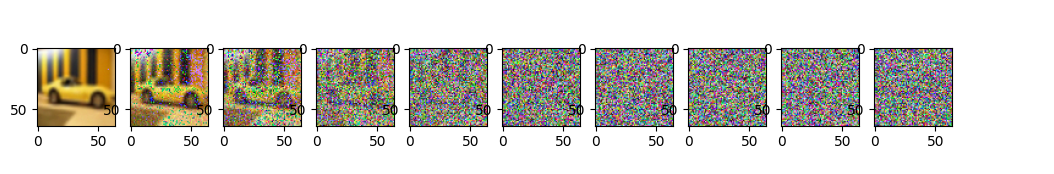

In [6]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(13, 2))
plt.axis('off')
num_images = 10
step_size = int(time_steps/num_images)

for idx in range(0, time_steps, step_size):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/step_size) + 1)
    img, noise = model.forward_diffusion_sample(image, t, torch.device('cpu'))
    model.show_tensor_image(img)

In [7]:
# Train the model
epoch_count = 1
print_interval = max(1, len(dataloader) // 100)
model_train_stats = model.train_model(
    train_loader=dataloader, epochs=epoch_count, print_interval=print_interval,
    batch_size=BATCH_SIZE, sample_img_size=IMG_SIZE
)

Cuda availability status: True
New best loss score: 0.8539333343505859
Saving epoch model...
New best loss score: 0.6933788061141968
Saving epoch model...
New best loss score: 0.5513235926628113
Saving epoch model...
New best loss score: 0.46679455041885376
Saving epoch model...
New best loss score: 0.42633163928985596
Saving epoch model...
Epoch 1 | step 006 Loss: 0.3774329721927643 
Creating Sample Image...
New best loss score: 0.3774329721927643
Saving epoch model...
New best loss score: 0.34791669249534607
Saving epoch model...
New best loss score: 0.32155826687812805
Saving epoch model...
New best loss score: 0.313615083694458
Saving epoch model...
New best loss score: 0.29948559403419495
Saving epoch model...
Epoch 1 | step 012 Loss: 0.3018411695957184 
Creating Sample Image...
New best loss score: 0.27932900190353394
Saving epoch model...
New best loss score: 0.2738979160785675
Saving epoch model...
New best loss score: 0.26273468136787415
Saving epoch model...
New best loss sco

In [8]:
model_train_stats

,epoch,batch,loss
0,1,1,0.853933
1,1,2,0.693379
2,1,3,0.551324
3,1,4,0.466795
4,1,5,0.426332
...,...,...,...
595,1,596,0.125316
596,1,597,0.130984
597,1,598,0.141397
598,1,599,0.134209
